In [1]:
# pip install funasr hyperpyyaml inflect openai-whisper datasets
# pip install diffusers==0.33.0

# vllm

import torch
from transformers import AutoProcessor, GenerationConfig

from modeling_bailingmm import BailingMMNativeForConditionalGeneration

model_name = "/mnt/bn/seed-aws-va/shwai.he/models/inclusionAI/Ming-Lite-Omni"
model_name = "/mnt/bn/seed-aws-va/shwai.he/models/inclusionAI/Ming-Lite-Omni-1.5"

# load model
model = BailingMMNativeForConditionalGeneration.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16,  # Use bfloat16 for memory efficiency
    attn_implementation="flash_attention_2",
    # attn_implementation="eager",
    load_image_gen=True,
    low_cpu_mem_usage=True,        # Minimize CPU memory during loading
    trust_remote_code=True, 
).to("cuda")  


Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [2]:
test_model = model.diffusion_loss
total = 0
for name, p in test_model.named_parameters():
    total += p.numel() 

total / 1e9

2.509653859

In [3]:

import torch
import torch.nn as nn

sparse_ratio = 1.


def count_parameters(model, only_trainable=False, exclude_label=None):
    """
    统计模型参数量
    Args:
        model: nn.Module, 模型
        only_trainable: bool, 是否只统计可训练参数
        exclude_label: list[str], 要排除的参数名关键词
    Returns:
        参数总数 (int)
    """
    if exclude_label is None:
        exclude_label = []

    total = 0
    for name, p in model.named_parameters():
        if any(label in name for label in exclude_label):
            continue
        if only_trainable and not p.requires_grad:
            continue
        print(name)
        total += p.numel() * sparse_ratio if "mlp" in name else p.numel()
    return total


exclude_label = ["moe_gen", "vit_model", "connector", "vae2llm", "llm2vae", "time_embedder", "pos_embed"]
exclude_label = ["visual"]

model = model.model

print("全部参数量:", count_parameters(model, exclude_label=exclude_label) /  1e9)
# print("可训练参数量:", count_parameters(model, only_trainable=True) /  1e9)


model.word_embeddings.weight
model.layers.0.attention.query_key_value.weight
model.layers.0.attention.dense.weight
model.layers.0.mlp.experts.0.gate_proj.weight
model.layers.0.mlp.experts.0.up_proj.weight
model.layers.0.mlp.experts.0.down_proj.weight
model.layers.0.mlp.experts.1.gate_proj.weight
model.layers.0.mlp.experts.1.up_proj.weight
model.layers.0.mlp.experts.1.down_proj.weight
model.layers.0.mlp.experts.2.gate_proj.weight
model.layers.0.mlp.experts.2.up_proj.weight
model.layers.0.mlp.experts.2.down_proj.weight
model.layers.0.mlp.experts.3.gate_proj.weight
model.layers.0.mlp.experts.3.up_proj.weight
model.layers.0.mlp.experts.3.down_proj.weight
model.layers.0.mlp.experts.4.gate_proj.weight
model.layers.0.mlp.experts.4.up_proj.weight
model.layers.0.mlp.experts.4.down_proj.weight
model.layers.0.mlp.experts.5.gate_proj.weight
model.layers.0.mlp.experts.5.up_proj.weight
model.layers.0.mlp.experts.5.down_proj.weight
model.layers.0.mlp.experts.6.gate_proj.weight
model.layers.0.mlp.expe

In [2]:
# build processor
processor = AutoProcessor.from_pretrained(".", trust_remote_code=True)

# qa
messages = [
    {
        "role": "HUMAN",
        "content": [
            {"type": "text", "text": "请详细介绍鹦鹉的生活习性。"}
        ],
    },
]

# 1. Format inputs using chat template
text = processor.apply_chat_template(messages, add_generation_prompt=True)

# 2. Extract vision/audio data
image_inputs, video_inputs, audio_inputs = processor.process_vision_info(messages)

# 3. Prepare tensor inputs
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    audios=audio_inputs,
    return_tensors="pt",
)
inputs = inputs.to(model.device)
for k in inputs.keys():
    if k == "pixel_values" or k == "pixel_values_videos" or k == "audio_feats":
        inputs[k] = inputs[k].to(dtype=torch.bfloat16)

# 4. Configure generation
generation_config = GenerationConfig.from_dict({'no_repeat_ngram_size': 10})
generated_ids, _ = model.generate(
    **inputs,
    max_new_tokens=512,
    use_cache=True,
    eos_token_id=processor.gen_terminator,
    generation_config=generation_config,
)
generated_ids_trimmed = [
        out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
    ]

# 5. Decode output
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)[0]
print(output_text)
# Output:

# 鹦鹉是一种非常聪明和社交性强的鸟类，它们的生活习性非常丰富和有趣。以下是一些关于鹦鹉生活习性的详细介绍：
# ### 1. **栖息地**
# 鹦鹉主要分布在热带和亚热带地区，包括非洲、亚洲、澳大利亚和南美洲。它们通常生活在森林、草原、沙漠和城市环境中。不同种类的鹦鹉对栖息地的要求有所不同，但大多数鹦鹉喜欢有丰富植被和水源的地方。
# ### 2. **饮食**
# 鹦鹉是杂食性动物，它们的饮食非常多样化。它们的食物包括种子、坚果、水果、蔬菜、花蜜和昆虫。鹦鹉的喙非常强壮，能够轻松地打开坚硬的果壳和坚果。一些鹦鹉还会吃泥土或沙子，以帮助消化和补充矿物质。
# ......

鹦鹉是一种非常受欢迎的宠物鸟，它们以其鲜艳的羽毛、聪明和社交性而闻名。以下是鹦鹉的一些生活习性：

### 1. **栖息环境**
鹦鹉通常生活在热带和亚热带地区，包括雨林、草原和沙漠。它们喜欢温暖的气候，但也能适应一些较冷的环境。

### 2. **饮食**
鹦鹉是杂食性动物，它们的饮食主要包括：
- **种子**：如葵花籽、燕麦等。
- **水果**：如苹果、香蕉、葡萄等。
- **蔬菜**：如胡萝卜、菠菜等。
- **坚果**：如核桃、杏仁等。
- **特制鹦鹉饲料**：市面上有专门的鹦鹉饲料，包含了它们所需的各种营养成分。

### 3. **社交行为**
鹦鹉是非常社交的动物，它们喜欢与人类和其他鸟类互动。它们可以通过模仿声音和语言来与人类交流。

### 4. **繁殖**
鹦鹉通常在春季繁殖。雌性鹦鹉会在树洞或人工提供的巢箱中产卵，每次产卵数量通常在2到6枚之间。孵化期约为18到30天，幼鸟在孵化后需要父母的照顾和喂养。

### 5. **活动时间**
鹦鹉是白天活动的鸟类，它们在白天非常活跃，喜欢飞翔和觅食。夜晚则通常休息。

### 6. **寿命**
鹦鹉的寿命因种类而异，一般在20到50年之间，有些品种可以活到60年以上。

### 7. **智力**
鹦鹉是非常聪明的鸟类，它们能够解决复杂的问题，学习新的技能，甚至可以模仿人类的语言。

### 8. **健康**
鹦鹉需要定期进行健康检查，以确保它们的饮食和生活方式是健康的。常见的健康问题包括羽毛问题、呼吸道感染和营养不良。

### 9. **环境需求**
鹦鹉需要一个宽敞的笼子，笼子内应有足够的空间供它们飞翔和玩耍。笼子底部应铺上适当的垫料，如木屑或纸屑。

### 10. **训练**
鹦鹉可以通过正向强化训练来学习各种技巧和行为，如飞翔、握手和说话。训练需要耐心和一致性。

总的来说，鹦鹉是非常有趣和聪明的宠物，但它们也需要主人的细心照顾和关注。了解它们的生活习性，可以帮助你更好地照顾它们，让它们健康快乐地生活。


In [ ]:
# # Preparation for inference
# cot_prompt = "SYSTEM: You are a helpful assistant. When the user asks a question, your response must include two parts: first, the reasoning process enclosed in <thinking>...</thinking> tags, then the final answer enclosed in <answer>...</answer> tags. The critical answer or key result should be placed within \\boxed{}.\n"
# cot_prompt = "SYSTEM: You are a helpful assistant. When the user asks a question, your response must include two parts: first, the reasoning process enclosed in <thinking>...</thinking> tags, then the final answer enclosed in <answer>...</answer> tags. The critical answer or key result should be placed within \\boxed{}.\n"

# # And your input message should be like this:
# messages = [
#     {
#         "role": "HUMAN",
#         "content": [
#             {"type": "image", "image": "/mnt/bn/seed-aws-va/shwai.he/Ming/t2i.jpg"},
#             # {"type": "text", "text": "Please describe the image in detail."},
#             {"type": "text", "text": "What kind of flower is this?"},

#         ],
#     },
# ]


# text = processor.apply_chat_template(messages, add_generation_prompt=True)
# print(text)
# image_inputs, video_inputs, audio_inputs = processor.process_vision_info(messages)
# inputs = processor(
#     text=[text],
#     images=image_inputs,
#     videos=video_inputs,
#     audios=audio_inputs,
#     return_tensors="pt",
# )
# inputs = inputs.to(model.device)
# for k in inputs.keys():
#     if k == "pixel_values" or k == "pixel_values_videos" or k == "audio_feats":
#         inputs[k] = inputs[k].to(dtype=torch.bfloat16)

# # call generate
# generation_config = GenerationConfig.from_dict({'no_repeat_ngram_size': 10})
# generated_ids, attentions = model.generate(
#     **inputs,
#     max_new_tokens=512,
#     use_cache=True,
#     eos_token_id=processor.gen_terminator,
#     generation_config=generation_config,
# )
# generated_ids_trimmed = [
#         out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
#     ]
# output_text = processor.batch_decode(
#     generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
# )[0]
# print(output_text)

: 

In [ ]:
# import json

# record=True

# for i, layer in enumerate(model.model.model.layers):
#     mlp = layer.mlp 
#     if hasattr(mlp, "experts"):
#         for expert in mlp.experts:
#             expert.sparse_mode = "prune"
#             # expert.record = record

#             # expert.register_buffer("act_sum", torch.zeros(expert.intermediate_size))     # ∑|h|
#             # expert.register_buffer("act_cnt", torch.tensor(0, dtype=torch.long))       # batch 计数
#     else: 
#         mlp.sparse_mode = "prune"    
#         # mlp.record = record

#         # mlp.register_buffer("act_sum", torch.zeros(layer.mlp.intermediate_size))     # ∑|h|
#         # mlp.register_buffer("act_cnt", torch.tensor(0, dtype=torch.long))       # batch 计数

# for i, layer in enumerate(model.model.model.layers):
#     layer.record = record

# def extract_prompts(jsonl_path, output_txt_path = None):
#     prompts = []
#     with open(jsonl_path, "r") as f:
#         for line in f:
#             data = json.loads(line)
#             if "prompt" in data:
#                 prompts.append(data["prompt"])
#     if output_txt_path is not None:
#         with open(output_txt_path, "w") as f:
#             for prompt in prompts:
#                 f.write(prompt + "\n")
#     return prompts

# if __name__ == "__main__":
#     jsonl_path = "/mnt/bn/seed-aws-va/shwai.he/cdt-hf/eval/gen/geneval/prompts/evaluation_metadata_long.jsonl"  # Replace with your path if different
#     output_txt_path = "extracted_prompts.txt"
#     prompts = extract_prompts(jsonl_path, output_txt_path)
#     # print(f"Extracted {len(open(output_txt_path).readlines())} prompts to {output_txt_path}")
#     print(len(prompts))


: 

In [ ]:
# lm = model.vision

# total_params = sum(p.numel() for p in lm.parameters())
# trainable_params = sum(p.numel() for p in lm.parameters() if p.requires_grad)

# print(f"Total params: {total_params / 1e9:,}")
# print(f"Trainable params: {trainable_params /1e9:,}")


: 

{'image_gen_cfg': 6.0, 'image_gen_steps': 20, 'image_gen_width': 480, 'image_gen_height': 544}
[Hyper-Param]: 
   do_img_cfg: True 
   guidance_scale: 6.0 
   img_cfg: 2.0 
   cfg_mode: 1


  0%|          | 0/20 [00:00<?, ?it/s]

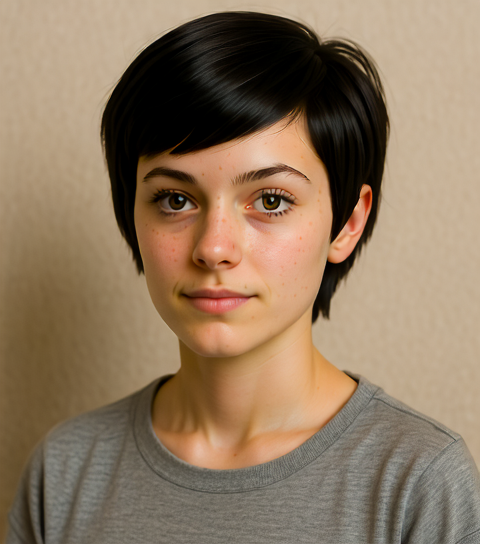

In [5]:
# Image generation mode currently limits the range of input pixels.
gen_input_pixels = 451584
processor = AutoProcessor.from_pretrained(".", trust_remote_code=True)

processor.max_pixels = gen_input_pixels
processor.min_pixels = gen_input_pixels

prompt = "A female cosplayer portraying an ethereal fairy or elf, wearing a flowing dress made of delicate fabrics in soft, mystical colors like emerald green and silver. She has pointed ears, a gentle, enchanting expression, and her outfit is adorned with sparkling jewels and intricate patterns. The background is a magical forest with glowing plants, mystical creatures, and a serene atmosphere."
prompt = "Draw a girl with short hair."
# prompt = prompts[0]

def generate(messages, processor, model, **image_gen_param):
    text = processor.apply_chat_template(messages, add_generation_prompt=True)
    image_inputs, video_inputs, audio_inputs = processor.process_vision_info(messages)

    inputs = processor(
        text=[text],
        images=image_inputs,
        videos=video_inputs,
        audios=audio_inputs,
        return_tensors="pt",
    ).to(model.device)

    for k in inputs.keys():
        if k == "pixel_values" or k == "pixel_values_videos" or k == "audio_feats":
            inputs[k] = inputs[k].to(dtype=torch.bfloat16)
    
    print(image_gen_param)
    image, attentions = model.generate(
        **inputs,
        image_gen=True,
        **image_gen_param,
    )
    return image, attentions

messages = [
    {
        "role": "HUMAN",
        "content": [
            {"type": "text", "text": prompt},
        ],
    }
]
image, attentions = generate(
   messages=messages, processor=processor, model=model, 
   image_gen_cfg=6.0, image_gen_steps=20, image_gen_width=480, image_gen_height=544
)
# image.save("./t2i.jpg")
display(image)

In [12]:
attentions[1].size()

torch.Size([1, 16, 358, 358])

In [15]:

import torch
import numpy as np
import matplotlib.pyplot as plt
import os


def visualize_attention_sink_per_head(
    attn: torch.Tensor,
    token_labels=None,
    save_dir=None,
    topk=5,
    exclude_self=True,
):
    """
    Visualize attention sink for each head and return numeric results.

    Args:
        attn: torch.Tensor, shape [H, S, S]
        token_labels: list[str], optional labels for tokens
        save_dir: optional str, directory to save figures
        topk: int, number of top sink tokens to annotate
        exclude_self: bool, whether to zero out self-attention diagonal

    Returns:
        results: dict[head_idx -> dict]
            {
              head_idx: {
                  "sink_scores": torch.Tensor [S],
                  "top_indices": list[int],
                  "top_labels": list[str],
              }
            }
    """
    assert attn.ndim == 3, f"Expected [H,S,S], got {attn.shape}"
    H, S, _ = attn.shape
    attn = attn.detach().float().cpu()

    if token_labels is None:
        token_labels = [str(i) for i in range(S)]
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)

    results = {}

    for h in range(H):
        A = attn[h]
        if exclude_self:
            A = A.clone()
            A.fill_diagonal_(0.0)

        # sink score = mean over queries (i), for each key (j)
        sink_scores = A.mean(dim=0)
        top_values, top_indices = torch.topk(sink_scores, topk)
        top_labels = [token_labels[i] for i in top_indices]

        # === Heatmap === #
        plt.figure(figsize=(6, 5))
        plt.imshow(A, cmap='viridis', interpolation='nearest', aspect='auto')
        plt.colorbar(label='Attention weight')
        plt.title(f'Head {h} - Attention Heatmap')
        plt.xlabel('Key tokens')
        plt.ylabel('Query tokens')
        if save_dir:
            if not os.path.exists(f"{save_dir}/layer{l}"):
                os.makedirs(f"{save_dir}/layer{l}")
            plt.savefig(os.path.join(f"{save_dir}/layer{l}", f'head_{h:02d}_heatmap.png'), bbox_inches='tight', dpi=150)
            plt.close()
        else:
            plt.show()

        # === Sink curve === #
        plt.figure(figsize=(6, 3))
        x = np.arange(S)
        plt.plot(x, sink_scores.numpy(), marker='o', linewidth=1)
        for rank, idx in enumerate(top_indices.tolist(), 1):
            plt.scatter([idx], [sink_scores[idx]], s=50)
            plt.text(idx, sink_scores[idx].item(), f"#{rank}:{token_labels[idx]}", ha='center', va='bottom', fontsize=8)
        plt.title(f'Head {h} - Sink Scores (top-{topk})')
        plt.xlabel('Token position')
        plt.ylabel('Avg incoming attention')
        plt.tight_layout()
        if save_dir:
            if not os.path.exists(f"{save_dir}/layer{l}"):
                os.makedirs(f"{save_dir}/layer{l}")
            plt.savefig(os.path.join(f"{save_dir}/layer{l}", f'head_{h:02d}_sink.png'), bbox_inches='tight', dpi=150)
            plt.close()
        else:
            plt.show()

        results[h] = {
            "sink_scores": sink_scores,           # torch.Tensor [S]
            "top_indices": top_indices.tolist(),  # list[int]
            "top_labels": top_labels,             # list[str]
            "top_values": top_values.tolist(),    # list[float]
        }


        print(f"[Layer {l} Head {h:02d}] top-{topk} sink tokens: {list(zip(top_indices.tolist(), top_values))}")

    return results

# ==== Example usage ====
if __name__ == "__main__":
    # H, S = 28, 32
    # attn = torch.randn(H, S, S)
    # attn = torch.softmax(attn, dim=-1)  # valid attention maps

    for l in range(28):
        attn = attentions[l][0]
        S = attn.shape[-1]
        H = attn.shape[0]
        labels = [f"t{i}" for i in range(S)]

        visualize_attention_sink_per_head(attn, token_labels=labels, save_dir="./sink_ming", topk=3)



[Layer 0 Head 00] top-3 sink tokens: [(40, tensor(0.1573)), (162, tensor(0.1193)), (231, tensor(0.1022))]


[Layer 0 Head 01] top-3 sink tokens: [(162, tensor(0.1714)), (40, tensor(0.1377)), (231, tensor(0.1030))]
[Layer 0 Head 02] top-3 sink tokens: [(40, tensor(0.1826)), (231, tensor(0.0587)), (162, tensor(0.0583))]
[Layer 0 Head 03] top-3 sink tokens: [(162, tensor(0.0580)), (40, tensor(0.0432)), (231, tensor(0.0344))]
[Layer 0 Head 04] top-3 sink tokens: [(40, tensor(0.3508)), (70, tensor(0.1430)), (49, tensor(0.0443))]
[Layer 0 Head 05] top-3 sink tokens: [(40, tensor(0.1048)), (162, tensor(0.0686)), (231, tensor(0.0429))]
[Layer 0 Head 06] top-3 sink tokens: [(40, tensor(0.2407)), (70, tensor(0.0547)), (49, tensor(0.0493))]
[Layer 0 Head 07] top-3 sink tokens: [(40, tensor(0.1174)), (162, tensor(0.0314)), (85, tensor(0.0262))]
[Layer 0 Head 08] top-3 sink tokens: [(40, tensor(0.3616)), (70, tensor(0.1196)), (49, tensor(0.0820))]
[Layer 0 Head 09] top-3 sink tokens: [(40, tensor(0.4225)), (70, tensor(0.2012)), (49, tensor(0.0740))]
[Layer 0 Head 10] top-3 sink tokens: [(40, tensor(0.380

In [ ]:
import torch.nn.functional as F

record = True
COS_SIM = {}

TYPES = ["block", "attn", "mlp"]
for Type in TYPES:
    COS_SIM[Type] = [] 

for i, layer in enumerate(model.model.model.layers):

    # print(f"layer.input: {layer.input} | layer.output: {layer.output}")
    # block
    cos_sim = F.cosine_similarity(layer.input, layer.output, dim=-1)  # (total_token_num)
    cos_sim = cos_sim.mean()
    COS_SIM["block"].append(cos_sim.cpu().data.item())
    # attn
    # print(f"input_output: {cos_sim}")
    cos_sim = F.cosine_similarity(layer.input, layer.residual, dim=-1)  # (total_token_num)
    cos_sim = cos_sim.mean()
    COS_SIM["attn"].append(cos_sim.cpu().data.item())
    # print(f"input_residual: {cos_sim}")

    # mlp
    cos_sim = F.cosine_similarity(layer.residual, layer.output, dim=-1)  # (total_token_num)
    cos_sim = cos_sim.mean()
    COS_SIM["mlp"].append(cos_sim.cpu().data.item())
    # print(f"residual_output: {cos_sim}")



: 

In [ ]:
Type = "mlp"
keep_ratio = 0.5

COS_SIM_TYPE = COS_SIM[Type]
topk_weight, topk_index = torch.topk(torch.tensor(COS_SIM_TYPE), int((1 - keep_ratio) * len(COS_SIM_TYPE)), dim=-1)

for i, layer in enumerate(model.model.model.layers):
    if i in topk_index:
        layer.skip_mode = Type
    else: 
        layer.skip_mode = None

: 

In [ ]:
# @torch.no_grad()
# def prune_mlp(layer, keep_ratio: float = 0.5, compressed_layers: list = [], update: bool = True):
#     """
#     • keep_ratio 0.5  →  4×d → 2×d
#     • 调用前需先跑若干 batch，让 act_sum / act_cnt 累积到 >0
#     """
#     if layer.act_cnt == 0:
#         raise RuntimeError(
#             f"[Layer {layer.layer_idx}] prune_mlp() called before any forward pass."
#         )

#     # importance_i = ⟨|h_i|⟩ × ‖W_{d,i}‖₂
#     act_mean = layer.act_sum / layer.act_cnt
#     col_norm = layer.down_proj.weight.norm(dim=0).cpu()
#     score    = act_mean * col_norm

#     k = int(layer.intermediate_size * keep_ratio)
#     keep = torch.topk(score, k).indices.sort().values      # ascending order
#     keep_unsorted = torch.topk(score, k).indices

#     # print(f"keep_unsorted: {keep_unsorted}")

#     if update:  
#         if layer.layer_idx in compressed_layers:
#         #     # --- 裁剪权重 ---
#             layer.gate_proj.weight.data = layer.gate_proj.weight.data[keep]
#             layer.up_proj.weight.data   = layer.up_proj.weight.data[keep]
#             layer.down_proj.weight.data = layer.down_proj.weight.data[:, keep]
#             # --- 更新 meta ---
#             layer.intermediate_size      = k
#             layer.gate_proj.out_features = k
#             layer.up_proj.out_features   = k
#             layer.down_proj.in_features  = k

#     return keep_unsorted.tolist()



: 

In [ ]:
# keep_ratio = 0.5
# target_layer = "mlp"
# compressed_layers = range(len(model.model.model.layers))

# for i, layer in enumerate(model.model.model.layers):
#     mlp = layer.mlp 
#     if hasattr(mlp, "experts"):
#         for expert in mlp.experts:
#             if target_layer == "mlp":
#                 keep_und = prune_mlp(expert, keep_ratio=keep_ratio, compressed_layers=compressed_layers,)
#             elif target_layer == "attn": 
#                 keep = prune_attn(expert, keep_ratio=keep_ratio,)

#     else: 
#         if target_layer == "mlp":
#             keep_und = prune_mlp(mlp, keep_ratio=keep_ratio, compressed_layers=compressed_layers,)
#         elif target_layer == "attn": 
#             keep = prune_attn(mlp, keep_ratio=keep_ratio,)



: 

In [ ]:

# 取出子模块
lm = model.model.model

# 统计总参数量
total_params = sum(p.numel() for p in lm.parameters())
trainable_params = sum(p.numel() for p in lm.parameters() if p.requires_grad)

print(f"Total params: {total_params / 1e9:,}")
print(f"Trainable params: {trainable_params /1e9:,}")


: 

In [ ]:
# Image generation mode currently limits the range of input pixels.
gen_input_pixels = 451584
processor = AutoProcessor.from_pretrained(".", trust_remote_code=True)

processor.max_pixels = gen_input_pixels
processor.min_pixels = gen_input_pixels

prompt = "A female cosplayer portraying an ethereal fairy or elf, wearing a flowing dress made of delicate fabrics in soft, mystical colors like emerald green and silver. She has pointed ears, a gentle, enchanting expression, and her outfit is adorned with sparkling jewels and intricate patterns. The background is a magical forest with glowing plants, mystical creatures, and a serene atmosphere."
# prompt = "Draw a girl with short hair."
prompt = prompts[0]

def generate(messages, processor, model, **image_gen_param):
    text = processor.apply_chat_template(messages, add_generation_prompt=True)
    image_inputs, video_inputs, audio_inputs = processor.process_vision_info(messages)

    inputs = processor(
        text=[text],
        images=image_inputs,
        videos=video_inputs,
        audios=audio_inputs,
        return_tensors="pt",
    ).to(model.device)

    for k in inputs.keys():
        if k == "pixel_values" or k == "pixel_values_videos" or k == "audio_feats":
            inputs[k] = inputs[k].to(dtype=torch.bfloat16)
    
    print(image_gen_param)
    image, attentions = model.generate(
        **inputs,
        image_gen=True,
        **image_gen_param,
    )
    return image

messages = [
    {
        "role": "HUMAN",
        "content": [
            {"type": "text", "text": prompt},
        ],
    }
]

# sparse_mode = "random"
sparse_mode = "dense"

for i, layer in enumerate(model.model.model.layers):
    mlp = layer.mlp 
    if hasattr(mlp, "experts"):
        for expert in mlp.experts:
            expert.sparse_mode = sparse_mode
    else: 
        mlp.sparse_mode = sparse_mode    
    

image = generate(
   messages=messages, processor=processor, model=model, 
   image_gen_cfg=6.0, image_gen_steps=20, image_gen_width=480, image_gen_height=544
)
# image.save("./t2i.jpg")
display(image)

: 

: 

: 

: 

: 